# Import Statements

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from gensim.models import Word2Vec
import gensim
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.utils import simple_preprocess
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob

c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocessing

In [2]:
data = pd.read_csv("./data/CUBE_WEBANALYTICS_SEARCHES_202410101536.csv")

In [3]:
# Preprocessing
data = data.drop_duplicates(subset=['SESSION_ID', 'SEARCH_TERM'])
data = data[~data['SEARCH_TERM'].str.contains(r'http[s]?://|^ecli:', na=False)]
data = data[~data['SEARCH_TERM'].str.contains(r'@', na=False)]
data['SEARCH_TERM'] = (data['SEARCH_TERM']
                       .str.replace(r'[\t\n\\\"(),]', '', regex=True)
                       .str.replace(r'\b(de|het|een|van|en|in|op|voor|bij|uit|ter|zake|terzake)\b', '', regex=True)
                       .str.replace(r'(\b\d{2})([/:])', r'20\1\2', regex=True)
                       .str.replace(r'\bartikel\b', 'art.', regex=True)
                       .str.replace(r'\bart(?!\.)\b', 'art.', regex=True)
                       .str.replace(r'\bmet betrekking tot\b', 'm.b.t.', regex=True)
                       .str.replace(r'\s+', ' ', regex=True)
                       .str.strip())
data.to_csv('./data/data.csv', index=False)

In [4]:
df = pd.read_csv('./data/data.csv')
search_terms = df['SEARCH_TERM'].astype(str).tolist()

# Vectorization

In [5]:
# WORD2VEC MODEL
# Model and Vectorization
model = Word2Vec(sentences=search_terms, vector_size=100, window=5, min_count=1, workers=4)
model.save('./model/model_word2vec.model')
word2vec_vectors = [np.mean([model.wv[token] for token in tokens if token in model.wv.key_to_index], axis=0) if tokens else np.zeros(model.vector_size) for tokens in search_terms]

# Save Vectors
df_vectors = pd.DataFrame(word2vec_vectors)
df_vectors.to_csv('./data/word2vec_vectors.csv', index=False)
word2vec_df = df_vectors

In [ ]:
# BERT
# Define a Dataset class for efficient batching
class SearchTermDataset(Dataset):
    def __init__(self, terms):
        self.terms = terms

    def __len__(self):
        return len(self.terms)

    def __getitem__(self, idx):
        return self.terms[idx]

# Create Dataset and DataLoader
dataset = SearchTermDataset(search_terms)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').cuda()  # Ensure model is on GPU

# Function to process and save vectors incrementally
def process_and_save_vectors(dataloader, tokenizer, model, output_prefix="bert_vectors"):
    model.eval()
    all_vectors = []
    for batch_idx, batch in enumerate(dataloader):
        # Tokenize batch
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        encoded_input = {key: val.cuda() for key, val in encoded_input.items()}  # Move to GPU

        # Process batch through BERT
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_vectors = model_output.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token

        # Save batch to disk
        batch_df = pd.DataFrame(batch_vectors)
        batch_df.to_csv(f"{output_prefix}_batch_{batch_idx}.csv", index=False)

        # Optional: Append to all_vectors if in-memory collection is needed
        all_vectors.append(batch_vectors)

        # Clear GPU memory
        torch.cuda.empty_cache()

    # Combine all vectors into one DataFrame if needed
    return np.vstack(all_vectors) if all_vectors else None

# Process data and save vectors
process_and_save_vectors(dataloader, tokenizer, model)

# Path to the batch CSV files
batch_files = glob.glob("bert_vectors_batch_*.csv")

# Sort files numerically by their batch number
batch_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Read and concatenate all batch files
all_data = pd.concat((pd.read_csv(file) for file in batch_files), ignore_index=True)

# Save the combined DataFrame to a single CSV file
all_data.to_csv("./data/bert_vectors.csv", index=False)

print("All files have been combined into 'bert_vectors.csv'.")

In [ ]:
# ROBBERT
# Define a Dataset class for efficient batching
class SearchTermDataset(Dataset):
    def __init__(self, terms):
        self.terms = terms

    def __len__(self):
        return len(self.terms)

    def __getitem__(self, idx):
        return self.terms[idx]

# Create Dataset and DataLoader
dataset = SearchTermDataset(search_terms)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained BERT model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')
model = RobertaModel.from_pretrained('pdelobelle/robbert-v2-dutch-base').cuda()  # Ensure model is on GPU

# Function to process and save vectors incrementally
def process_and_save_vectors(dataloader, tokenizer, model, output_prefix="robbert_vectors"):
    model.eval()
    all_vectors = []
    for batch_idx, batch in enumerate(dataloader):
        # Tokenize batch
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
        encoded_input = {key: val.cuda() for key, val in encoded_input.items()}  # Move to GPU

        # Process batch through BERT
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_vectors = model_output.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token

        # Save batch to disk
        batch_df = pd.DataFrame(batch_vectors)
        batch_df.to_csv(f"{output_prefix}_batch_{batch_idx}.csv", index=False)

        # Optional: Append to all_vectors if in-memory collection is needed
        all_vectors.append(batch_vectors)

        # Clear GPU memory
        torch.cuda.empty_cache()

    # Combine all vectors into one DataFrame if needed
    return np.vstack(all_vectors) if all_vectors else None

# Process data and save vectors
process_and_save_vectors(dataloader, tokenizer, model)

# Path to the batch CSV files
batch_files = glob.glob("robbert_vectors_batch_*.csv")

# Sort files numerically by their batch number
batch_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Read and concatenate all batch files
all_data = pd.concat((pd.read_csv(file) for file in batch_files), ignore_index=True)

# Save the combined DataFrame to a single CSV file
all_data.to_csv("./data/robbert_vectors.csv", index=False)

print("All files have been combined into 'robbert_vectors.csv'.")

Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Clustering & Topic Modelling

In [7]:
# Split the data into training and testing sets
train_vectors, test_vectors, train_df, test_df = train_test_split(
    word2vec_df, df, test_size=0.3, random_state=42
)

# Set the number of clusters
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the KMeans model on the training data
kmeans.fit(train_vectors)

# Evaluate the clustering performance on the training data
train_silhouette = silhouette_score(train_vectors, kmeans.labels_)
train_davies_bouldin = davies_bouldin_score(train_vectors, kmeans.labels_)
train_calinski_harabasz = calinski_harabasz_score(train_vectors, kmeans.labels_)

print(f"Training KMeans Silhouette Score: {train_silhouette:.4f}")
print(f"Training Davies-Bouldin Index: {train_davies_bouldin:.3f}")
print(f"Training Calinski-Harabasz Index: {train_calinski_harabasz:.3f}")

# Predict cluster labels for the testing data
test_labels = kmeans.predict(test_vectors)

# Evaluate clustering performance on the testing data
test_silhouette = silhouette_score(test_vectors, test_labels)
test_davies_bouldin = davies_bouldin_score(test_vectors, test_labels)
test_calinski_harabasz = calinski_harabasz_score(test_vectors, test_labels)

print(f"Testing KMeans Silhouette Score: {test_silhouette:.4f}")
print(f"Testing Davies-Bouldin Index: {test_davies_bouldin:.3f}")
print(f"Testing Calinski-Harabasz Index: {test_calinski_harabasz:.3f}")

# Add the cluster labels to the original DataFrames
train_df['KMeans_Cluster'] = kmeans.labels_
test_df['KMeans_Cluster'] = test_labels

# Combine the train and test DataFrames if needed
final_df = pd.concat([train_df, test_df], axis=0)

# Save the final DataFrame with cluster labels
final_df.to_csv('./data/labeled_data.csv', index=False)

c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training KMeans Silhouette Score: 0.5981
Training Davies-Bouldin Index: 0.820
Training Calinski-Harabasz Index: 379207.469
Testing KMeans Silhouette Score: 0.5974
Testing Davies-Bouldin Index: 0.811
Testing Calinski-Harabasz Index: 163023.680


c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

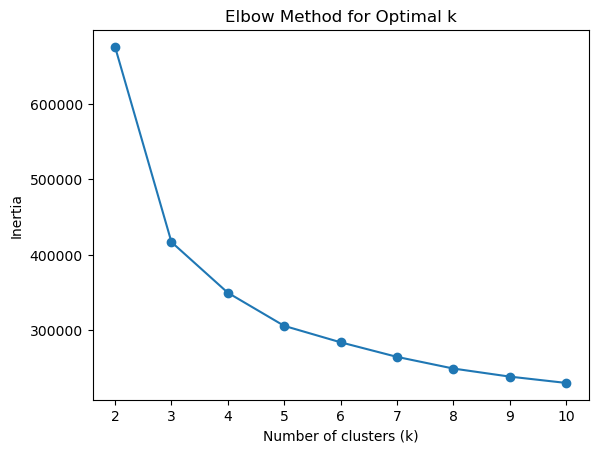

In [8]:
# Determine the Optimal Number of Clusters (Elbow Method)
# Before applying KMeans or hierarchical, use the elbow method to identify the ideal number of clusters:

inertia = []
k_values = range(2, 11)  # Try clusters from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(word2vec_df)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# As we increase the number of clusters, the within-cluster sum of squares (WCSS; inertia) value begins to decrease.
# Notably, the WCSS is at its highest when K=1.

In [9]:
# K-means clustering is a popular method for grouping data by assigning observations to clusters based on proximity to the cluster’s center.
# Apply KMeans Clustering
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(word2vec_df)

# Euclidean distance is used by default in KMeans to measure the similarity between word vectors.
# the lines represent the distance from each data point to its closest cluster center.

# Add the cluster labels to the original DataFrame
df['KMeans_Cluster'] = kmeans.labels_

c:\Users\marti\anaconda3\envs\gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


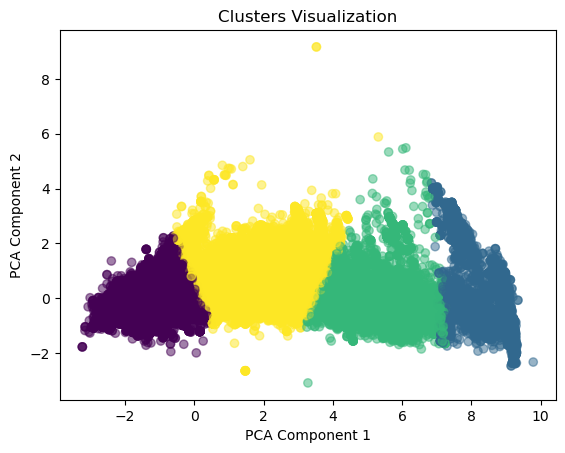

In [10]:
# Visualize Clusters
# For visualization, the Word2Vec vectors' dimensionality is reduced using PCA:

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(word2vec_df)

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.title('Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

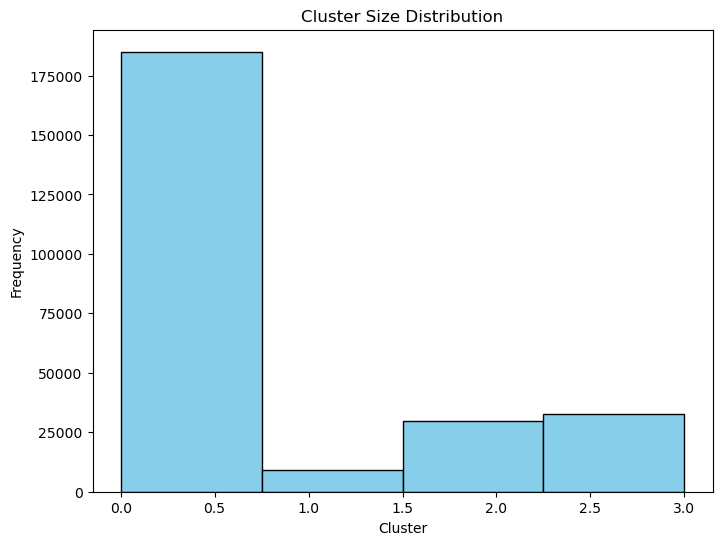

In [11]:
# Get the frequency of each cluster's data points
cluster_sizes = pd.Series(kmeans.labels_).value_counts()

# Ensure the histogram has exactly 4 bins (for k=4 clusters)
plt.figure(figsize=(8, 6))
plt.hist(kmeans.labels_, bins=4, edgecolor='black', color='skyblue')  # bins=4 forces 4 bins for k=4 clusters
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Silhouette Score: Measures how similar each point is to its own cluster compared to other clusters, indicating the quality of clustering.

# Compute Silhouette Score for KMeans
kmeans_score = silhouette_score(word2vec_df, kmeans.labels_)
davies_bouldin = davies_bouldin_score(word2vec_df, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(word2vec_df, kmeans.labels_)

print(f"KMeans Silhouette Score: {kmeans_score:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

# When interpreting Silhouette Scores, the goal is to assess how well the points are clustered,
# both in terms of:
  # cohesion (how close points within the same cluster are) and;
  # separation (how distinct the clusters are from one another).

# while the score for kmeans is higher, the distance between clusters is not significant as it's close to zero.
# conclusion: low quality of clustering.

KMeans Silhouette Score: 0.5979
Davies-Bouldin Index: 0.817
Calinski-Harabasz Index: 542221.945


In [13]:
# i tried from 2 - 60, but this is the moment of best results
df['SEARCH_TERM'] = df['SEARCH_TERM'].astype(str)
texts = df['SEARCH_TERM'].apply(lambda x: x.split())  # Tokenize each document
dictionary = corpora.Dictionary(texts)  # Create a dictionary
corpus = [dictionary.doc2bow(text) for text in texts]  # Convert to Bag-of-Words format

num_topics_list = [29, 30, 31]
coherence_scores = []

for num_topics in num_topics_list:
    lda_gensim = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_lda}")

# Choose the num_topics with the highest coherence score
best_num_topics = num_topics_list[coherence_scores.index(max(coherence_scores))]
print(f"Best number of topics: {best_num_topics}")

Num Topics: 29, Coherence Score: 0.5382555301995368
Num Topics: 30, Coherence Score: 0.5425185535922306
Num Topics: 31, Coherence Score: 0.5348829845712256
Best number of topics: 30


In [14]:
# Display top words for each topic

df['SEARCH_TERM'] = df['SEARCH_TERM'].fillna('')  # Handling NaN if any
df['SEARCH_TERM'] = df['SEARCH_TERM'].astype(str)  # Ensure all values are strings

# Create a CountVectorizer to transform the text into a bag-of-words model
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['SEARCH_TERM'])

# Choose the number of topics (you can experiment with this number)
num_topics = 30  # Adjust this based on your evaluation (typically 20-50 for large datasets)

# Fit the LDA model using sklearn
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display the top words in each topic
num_words = 10  # Number of words per topic to display (adjustable)

# Get the feature names (words) from the vectorizer
words = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-num_words-1:-1]  # Get the indices of the top words
    top_words = words[top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: nederland, verdrag, winst, tfb, deelneming, belastingverdrag, vertrouwensbeginsel, onroerend, goed, duitsland
Topic 2: fusie, auto, juridische, bijtelling, privégebruik, aandelen, inkoop, 54, ndfr, verrekening
Topic 3: onderneming, heffing, 2012, staking, winst, 2014, zorgkosten, maatstaf, verzoek, besluit
Topic 4: oeso, met, modelverdrag, pillar, inkomen, fraus, legis, kracht, model, terugwerkende
Topic 5: art, vpb, wet, lid, 13, 10a, 17, 14, sw, commentaar
Topic 6: waardering, waarde, stichting, 2022, den, vergoeding, schadevergoeding, gebruik, haag, kind
Topic 7: woning, eigen, belasting, dubbele, voorkoming, besluit, belastingrecht, bedrijfsopvolging, nieuw, internationaal
Topic 8: omzetbelasting, dividendbelasting, dividend, bezwaar, kst, beroep, tarief, internationale, kapitaal, schuld
Topic 9: buitenlandse, ovdb, splitsing, buitenland, eigendom, interne, belastingplicht, afschrijven, echtscheiding, belastingplan
Topic 10: inkomstenbelasting, 10, vaste, inrichting, vastg

In [15]:
from gensim import corpora, models
from gensim.models import CoherenceModel
import pandas as pd

# Ensure all values in 'SEARCH_TERM' are strings, and drop any missing values
df = df.dropna(subset=['SEARCH_TERM'])  # Drop rows where 'SEARCH_TERM' is NaN
df['SEARCH_TERM'] = df['SEARCH_TERM'].astype(str)  # Convert all values to strings

# Create cluster_texts dictionary
cluster_texts = {
    cluster: df[df['KMeans_Cluster'] == cluster]['SEARCH_TERM'].apply(lambda x: x.split())
    for cluster in df['KMeans_Cluster'].unique()
}

best_topics_per_cluster = {}
coherence_scores_per_cluster = {}

# Define range of topics to test for each cluster
num_topics_range = range(2, 6)

for cluster, texts in cluster_texts.items():
    print(f"Processing Cluster {cluster}...")
    dictionary = corpora.Dictionary(texts)  # Create dictionary for this cluster
    corpus = [dictionary.doc2bow(text) for text in texts]  # Convert to Bag-of-Words format

    coherence_scores = []

    for num_topics in num_topics_range:
        # Train LDA model
        lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f"Cluster {cluster}, Num Topics: {num_topics}, Coherence Score: {coherence_score}")

    # Find the best number of topics for this cluster
    best_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
    best_topics_per_cluster[cluster] = best_num_topics
    coherence_scores_per_cluster[cluster] = coherence_scores

# Print results
print("\nBest number of topics per cluster:")
for cluster, best_num in best_topics_per_cluster.items():
    print(f"Cluster {cluster}: {best_num} topics")

# Optionally, store coherence scores for further analysis

Processing Cluster 0...
Cluster 0, Num Topics: 2, Coherence Score: 0.35431895961120874
Cluster 0, Num Topics: 3, Coherence Score: 0.3760599355363132
Cluster 0, Num Topics: 4, Coherence Score: 0.33613069303561977
Cluster 0, Num Topics: 5, Coherence Score: 0.3968191762784329
Processing Cluster 2...
Cluster 2, Num Topics: 2, Coherence Score: 0.6625776601786044
Cluster 2, Num Topics: 3, Coherence Score: 0.6518312780287981
Cluster 2, Num Topics: 4, Coherence Score: 0.6214442747403008
Cluster 2, Num Topics: 5, Coherence Score: 0.6047102466800998
Processing Cluster 3...
Cluster 3, Num Topics: 2, Coherence Score: 0.38708273121773357
Cluster 3, Num Topics: 3, Coherence Score: 0.4027666412363053
Cluster 3, Num Topics: 4, Coherence Score: 0.4048384599689025
Cluster 3, Num Topics: 5, Coherence Score: 0.42109539439295557
Processing Cluster 1...
Cluster 1, Num Topics: 2, Coherence Score: 0.8116023767900291
Cluster 1, Num Topics: 3, Coherence Score: 0.8028904651005555
Cluster 1, Num Topics: 4, Cohere

In [16]:
# Display top words for the best LDA model in each cluster
for cluster, texts in cluster_texts.items():
    print(f"Cluster {cluster}:")
    dictionary = corpora.Dictionary(texts)  # Create dictionary for this cluster
    corpus = [dictionary.doc2bow(text) for text in texts]  # Convert to Bag-of-Words format

    # Train the LDA model with the best number of topics
    best_num_topics = best_topics_per_cluster[cluster]
    lda_model_best = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_num_topics, random_state=42)

    # Display top words for each topic
    for topic_id, topic in lda_model_best.show_topics(formatted=True, num_words=10):
        # Clean the output to show only the words (remove weights and quotes)
        words = [word.split('*')[1].strip('"') for word in topic.split(' + ')]
        print(f"  Topic {topic_id}: {', '.join(words)}")
    print()  # Adds a newline for separation between clusters

Cluster 0:
  Topic 0: art., wet, vpb, vennootschapsbelasting, wegwijs, dividendbelasting, inkomstenbelasting, lening, nederland, verdrag
  Topic 1: fiscale, ib, eenheid, loon, omzetbelasting, bv, winst, onderneming, deelnemingsvrijstelling, successiewet
  Topic 2: ob, fusie, of, juridische, aangifte, splitsing, deelneming, bor, eigendom, cv
  Topic 3: aandelen, goed, fiscaal, besluit, ib, belasting, vaste, koopmansgebruik, inrichting, aanslag
  Topic 4: btw, woning, eigen, awr, 3, box, overdrachtsbelasting, kosten, belang, schenking

Cluster 2:
  Topic 0: mbb, wpnr, ib, fbn, tfb, v-n, hr, 2022/30, 2023, 2001
  Topic 1: ntfr, bnb, nr., ftv, wfr, hr, ntfr-b, bw, ntfrb, mei

Cluster 3:
  Topic 0: ntfr, nr., hr, 2023, met, beschouwingen, annotatie, mr., besluit, wpnr
  Topic 1: art., awr, mbb, awb, 2022, 16, hoge, raad, besluit, den
  Topic 2: art., ib, wet, lid, 1, 2001, ob, 11, lb, bw
  Topic 3: art., wet, ib, vpb, 15, 13, lid, wbr, 6, 4
  Topic 4: art., vpb, wet, 3, awr, ib, lid, 10a, 2

In [17]:
# Function to perform LDA on each cluster
def perform_lda_on_cluster(df, num_topics=7):
    lda_results = {}

    for cluster_num in df['KMeans_Cluster'].unique():
        # Filter data by cluster
        cluster_data = df[df['KMeans_Cluster'] == cluster_num]

        # Drop rows where SEARCH_TERM is NaN
        cluster_data = cluster_data.dropna(subset=['SEARCH_TERM'])

        # Apply CountVectorizer to convert text into a bag-of-words representation
        # Assuming 'text_column' is the column containing text data in your DataFrame
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(cluster_data['SEARCH_TERM'])  # Change to your text column name

        # Perform LDA
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(X)

        # Store the results: Top words per topic
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words_idx = topic.argsort()[:-11:-1]  # Get the top 10 words for each topic
            top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
            topics.append(top_words)

        lda_results[cluster_num] = topics

    return lda_results

# Run LDA within each cluster
lda_results = perform_lda_on_cluster(df, num_topics=7)

# Print the topics within each cluster
for cluster_num, topics in lda_results.items():
    print(f"Cluster {cluster_num}:")
    for topic_idx, topic in enumerate(topics):
        print(f"  Topic {topic_idx+1}: {', '.join(topic)}")

Cluster 0:
  Topic 1: vpb, overdrachtsbelasting, bv, belasting, wegwijs, omzetbelasting, regeling, dubbele, successiewet, juridische
  Topic 2: woning, eigen, box, ob, vennootschapsbelasting, vaste, inrichting, aandelen, vastgoed, pensioen
  Topic 3: btw, awr, kosten, bor, waardering, loonbelasting, boete, besluit, bezwaar, aftrekbare
  Topic 4: fiscale, eenheid, inkomstenbelasting, onderneming, besluit, winst, awb, heffing, ib, btw
  Topic 5: dividendbelasting, niet, aandelen, btw, verhuur, aangifte, dividend, zonnepanelen, pillar, eigendom
  Topic 6: art, loon, oeso, nederland, excessief, belang, lenen, schenking, verdrag, aanslag
  Topic 7: wet, ib, art, goed, lening, koopmansgebruik, deelnemingsvrijstelling, onzakelijke, ntfr, vpb
Cluster 2:
  Topic 1: 2023, ntfr, kst, 2019, 2003, 2017, 2012, 36202, 36418, 2000
  Topic 2: mbb, 2022, fbn, tfb, ftv, wfr, 2019, 30, 2020, 10
  Topic 3: ntfr, 2018, 2022, 2014, nr, 2012, 2020, hr, kst, 2019
  Topic 4: 2021, ntfr, wpnr, 2019, 2020, 2015, 